### Agenda 
* Working with Nearest Neighbors
* Test-Based Distances
* Computing Mixed Distance Functions
* Nearest for Image Recognition


In [1]:
# import required libraries
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import tensorflow as tf
import requests
from tensorflow.python.framework import ops
ops.reset_default_graph()

In [2]:
sess = tf.Session()

In [3]:
housing_url = 'https://archive.ics.uci.edu/ml/machine-learning-databases/housing/housing.data'

In [4]:
housing_header = ['CRIM', 'ZN', 'INDUS', 'CHAS', 'NOX', 'RM', 'AGE', 'DIS', 'RAD', 'TAX', 'PTRATIO', 'B', 'LSTAT', 'MEDV']

* CRIM : per capita crime rate by town
* ZN : prop. of res. land zones
* INDUS : prop. of non-retail business acres
* CHAS : Charles river dummy variable
* NOX : nitrix oxides concentration / 10 M
* RM : Avg. # of rooms per building
* AGE : prop. of buildings built prior to 1940
* DIS : Weighted distances to employment centers
* RAD : Index of radian highway access
* TAX : Full tax rate value per $10k
* PTRATIO: Pupil/Teacher ratio by town
* B : 1000*(Bk-0.63)^2, Bk=prop. of blacks
* LSTAT : % lower status of pop

----y-data----
* MEDV : Median Value of homes 

In [5]:
cols_used = ['CRIM', 'INDUS', 'NOX', 'RM', 'AGE', 'DIS', 'TAX', 'PTRATIO', 'B', 'LSTAT']
num_features = len(cols_used)
housing_file = requests.get(housing_url)
housing_data = [[float(x) for x in y.split(' ') if len(x)>=1] for y in housing_file.text.split('\n') if len(y)>=1]

y_vals = np.transpose([np.array([y[13] for y in housing_data])])
x_vals = np.array([[x for i,x in enumerate(y) if housing_header[i] in cols_used] for y in housing_data])

## Min-Max Scaling
x_vals = (x_vals - x_vals.min(0)) / x_vals.ptp(0)

In [12]:
x_vals.ptp(0)

array([ 1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.])

In [13]:
help(x_vals.ptp)

Help on built-in function ptp:

ptp(...) method of numpy.ndarray instance
    a.ptp(axis=None, out=None)
    
    Peak to peak (maximum - minimum) value along a given axis.
    
    Refer to `numpy.ptp` for full documentation.
    
    See Also
    --------
    numpy.ptp : equivalent function



In [15]:
import numpy
help(numpy.ptp)

Help on function ptp in module numpy.core.fromnumeric:

ptp(a, axis=None, out=None)
    Range of values (maximum - minimum) along an axis.
    
    The name of the function comes from the acronym for 'peak to peak'.
    
    Parameters
    ----------
    a : array_like
        Input values.
    axis : int, optional
        Axis along which to find the peaks.  By default, flatten the
        array.
    out : array_like
        Alternative output array in which to place the result. It must
        have the same shape and buffer length as the expected output,
        but the type of the output values will be cast if necessary.
    
    Returns
    -------
    ptp : ndarray
        A new array holding the result, unless `out` was
        specified, in which case a reference to `out` is returned.
    
    Examples
    --------
    >>> x = np.arange(4).reshape((2,2))
    >>> x
    array([[0, 1],
           [2, 3]])
    
    >>> np.ptp(x, axis=0)
    array([2, 2])
    
    >>> np.ptp(x, axis=

In [16]:
train_indices = np.random.choice(len(x_vals), round(len(x_vals)*0.8), replace=False)
test_indices = np.array(list(set(range(len(x_vals))) - set(train_indices)))
x_vals_train = x_vals[train_indices]
x_vals_test = x_vals[test_indices]
y_vals_train = y_vals[train_indices]
y_vals_test = y_vals[test_indices]

In [17]:
k = 4
batch_size=len(x_vals_test)

In [18]:
x_data_train = tf.placeholder(shape=[None, num_features], dtype=tf.float32)
x_data_test = tf.placeholder(shape=[None, num_features], dtype=tf.float32)
y_target_train = tf.placeholder(shape=[None, 1], dtype=tf.float32)
y_target_test = tf.placeholder(shape=[None, 1], dtype=tf.float32)

In [19]:
distance = tf.reduce_sum(tf.abs(tf.sub(x_data_train, tf.expand_dims(x_data_test,1))), reduction_indices=2)

In [20]:
top_k_xvals, top_k_indices = tf.nn.top_k(tf.neg(distance), k=k)
x_sums = tf.expand_dims(tf.reduce_sum(top_k_xvals, 1),1)
x_sums_repeated = tf.matmul(x_sums,tf.ones([1, k], tf.float32))
x_val_weights = tf.expand_dims(tf.div(top_k_xvals,x_sums_repeated), 1)

top_k_yvals = tf.gather(y_target_train, top_k_indices)
prediction = tf.squeeze(tf.batch_matmul(x_val_weights,top_k_yvals), squeeze_dims=[1])
mse = tf.div(tf.reduce_sum(tf.square(tf.sub(prediction, y_target_test))), batch_size)

In [34]:
num_loops = int(np.ceil(len(x_vals_test)/batch_size))

print (num_loops)
for i in range(num_loops):
    min_index = i*batch_size
    max_index = min((i+1)*batch_size,len(x_vals_train))
    x_batch = x_vals_test[min_index:max_index]
    y_batch = y_vals_test[min_index:max_index]
    predictions = sess.run(prediction, feed_dict={x_data_train: x_vals_train, x_data_test: x_batch, y_target_train: y_vals_train, y_target_test: y_batch})
    batch_mse = sess.run(mse, feed_dict={x_data_train: x_vals_train, x_data_test: x_batch, y_target_train: y_vals_train, y_target_test: y_batch})

    print('Batch # '+ str(i+1) + ' MSE: ' + str(np.round(batch_mse,3)))

1
Batch # 1 MSE: 9.742


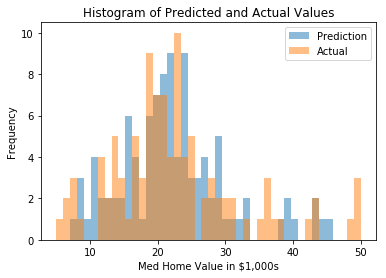

In [28]:
bins = np.linspace(5, 50, 45)

plt.hist(predictions, bins, alpha=0.5, label='Prediction')
plt.hist(y_batch, bins, alpha=0.5, label='Actual')
plt.title('Histogram of Predicted and Actual Values')
plt.xlabel('Med Home Value in $1,000s')
plt.ylabel('Frequency')
plt.legend(loc='upper right')
plt.show()

In [37]:
len(x_vals_test)

101

In [36]:
batch_size

101

In [38]:
help(tf.squeeze)

Help on function squeeze in module tensorflow.python.ops.array_ops:

squeeze(input, axis=None, name=None, squeeze_dims=None)
    Removes dimensions of size 1 from the shape of a tensor.
    
    Given a tensor `input`, this operation returns a tensor of the same type with
    all dimensions of size 1 removed. If you don't want to remove all size 1
    dimensions, you can remove specific size 1 dimensions by specifying
    `axis`.
    
    For example:
    
    ```prettyprint
    # 't' is a tensor of shape [1, 2, 1, 3, 1, 1]
    shape(squeeze(t)) ==> [2, 3]
              ```
    
    Or, to remove specific size 1 dimensions:
    
    ```prettyprint
    # 't' is a tensor of shape [1, 2, 1, 3, 1, 1]
    shape(squeeze(t, [2, 4])) ==> [1, 2, 3, 1]
    ```
    
    Args:
      input: A `Tensor`. The `input` to squeeze.
      axis: An optional list of `ints`. Defaults to `[]`.
        If specified, only squeezes the dimensions listed. The dimension
        index starts at 0. It is an error to